# Convolutional neural networks with PyTorch

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils import data
from torch.utils.data import DataLoader

# Reading a paper on deep learning

Let us say that you read a research paper explaining the architecture of the convolutional neural network used by the authors to carry out their data analysis. How will you try to reproduce their results?

Let us look at the following paper:

Rouet-Leduc, B., Hulbert, C., McBrearty, I. W., Johnson, P. A. (2020). Probing slow earthquakes with deep learning. Geophysical Research Letters, 47, e2019GL085870. https://doi.org/10.1029/2019GL085870.

<img src="figures/cnn_rouet-leduc.png" width="600">
<center>Schematic of the CNN and its architecture (Figure 1 from Rouet-Leduc et al. (2020).</center>

## Input

Spectrogram = Image with 129 * 95 pixels

## Convolution 16 * 16 kernel -> 32 Feature maps 114 * 80

<img src="figures/convolution.png" width="600">
<center>Convolution with kernel window (Fig. 6.2.1 from Dive into Deep Learning).</center>

129 - (16 - 1) = 114 and 95 - (16 - 1) = 80

We repeat the process 32 times with different kernels. The weights we need to learn with our optimization procedure are the 32 * 16 * 16 values used in the kernel windows.

In PyTorch, we would write:

In [2]:
torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=16)

Conv2d(1, 32, kernel_size=(16, 16), stride=(1, 1))

## Max-pooling 2 * 2 kernel -> 32 Feature maps 57 * 40

<img src="figures/max_pooling.png" width="600">
<center>Maximum pooling (Fig. 6.5.1 from Dive into Deep Learning).</center>

114 / 2 = 57 and 80 / 2 = 40

In PyTorch, we would write:

In [3]:
torch.nn.MaxPool2d(kernel_size=2)

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

## Description of neural network
(from Supplemetary Information from Rouet-Leduc et al., 2020)

The architecture of our CNN consists of three convolutional layers (with 32, 64, and 128 filters respectively, and each with a ReLu activation function, and one fully connected hidden layer (with 10 neurons and a sigmoid activation function), itself fully connected to the last visible layer, that has a sigmoid activation function as well. A max-pooling operation is applied after each convolution.

In [4]:
model = torch.nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=16),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2),
                            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=8),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2),
                            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4),
                            nn.Flatten(),
                            nn.Linear(36608, 10),
                            nn.Sigmoid(),
                            nn.Linear(10, 1),
                            nn.Sigmoid())

Let us have a look at the shape of a data point after each layer transformation.

In [5]:
X = torch.rand(size=(1, 1, 129, 95), dtype=torch.float32)
print('Initial input shape: \t', X.shape)
for layer in model:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Initial input shape: 	 torch.Size([1, 1, 129, 95])
Conv2d output shape: 	 torch.Size([1, 32, 114, 80])
ReLU output shape: 	 torch.Size([1, 32, 114, 80])
MaxPool2d output shape: 	 torch.Size([1, 32, 57, 40])
Conv2d output shape: 	 torch.Size([1, 64, 50, 33])
ReLU output shape: 	 torch.Size([1, 64, 50, 33])
MaxPool2d output shape: 	 torch.Size([1, 64, 25, 16])
Conv2d output shape: 	 torch.Size([1, 128, 22, 13])
Flatten output shape: 	 torch.Size([1, 36608])
Linear output shape: 	 torch.Size([1, 10])
Sigmoid output shape: 	 torch.Size([1, 10])
Linear output shape: 	 torch.Size([1, 1])
Sigmoid output shape: 	 torch.Size([1, 1])


# Example: LeNet-5 with images of digits

We load the MNIST dataset from PyTorch. It is a similar dataset as the images of digits from the previous labs, but images are now 28 * 28 = 784 pixels, and there are more data points in the training set and the test set.

In [6]:
mnist_train = torchvision.datasets.MNIST(root="data", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = torchvision.datasets.MNIST(root="data", train=False, transform=transforms.ToTensor(), download=True)

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


102.8%


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


112.7%
/opt/anaconda3/envs/uwdsgeo/lib/python3.9/site-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-h5re73co/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [7]:
print('There are {:d} images in the training set and {:d} images in the test set.'.format(len(mnist_train), len(mnist_test)))

There are 60000 images in the training set and 10000 images in the test set.


Let us have a look at a few images of digits.

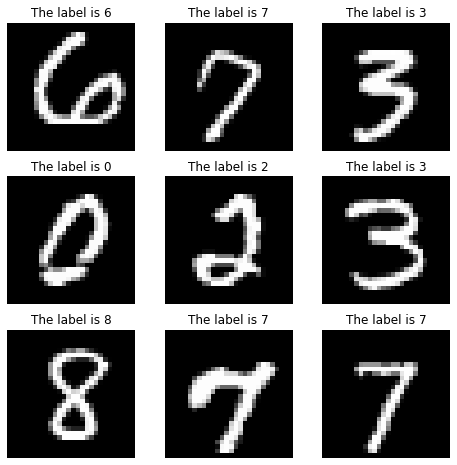

In [8]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    img, label = mnist_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title('The label is ' + str(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

We first define a function to reshape the image. For convolution neural networks, we can use the image as a 2D tensor, instead of flattening it before feeding it to the neural network.

In [9]:
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

We are going to use the LeNet-5 network architecture from LeCun et al. (1998).

In [10]:
model = torch.nn.Sequential(Reshape(),
                            nn.Conv2d(1, 6, kernel_size=5, padding=2),
                            nn.Sigmoid(),
                            nn.AvgPool2d(kernel_size=2, stride=2),
                            nn.Conv2d(6, 16, kernel_size=5),
                            nn.Sigmoid(),
                            nn.AvgPool2d(kernel_size=2, stride=2),
                            nn.Flatten(),
                            nn.Linear(16 * 5 * 5, 120),
                            nn.Sigmoid(),
                            nn.Linear(120, 84),
                            nn.Sigmoid(),
                            nn.Linear(84, 10))

Let us have a look at the shape of a data point after each layer transformation.

In [11]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
print('Initial input shape: \t', X.shape)
for layer in model:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Initial input shape: 	 torch.Size([1, 1, 28, 28])
Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


We can now prepare the training set and the test set for data loading.

In [12]:
train_dataloader = DataLoader(mnist_train, batch_size=256)
test_dataloader = DataLoader(mnist_test, batch_size=256)

Let us define how to train our neural network.

In [19]:
def train(model, n_epochs, lr, trainloader, testloader=None):

    # Save loss and accuracy for plotting
    loss_time = np.zeros(n_epochs)
    accuracy_time = np.zeros(n_epochs)

    # Initialize weights
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    model.apply(init_weights)

    # Define loss and optimization method
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()

    # Loop on number of epochs
    for epoch in range(n_epochs):
        # Initialize the loss
        running_loss = 0
        model.train()
        # Loop on samples in train set
        for i, (X, y) in enumerate(trainloader):
            optimizer.zero_grad()
            y_hat = model(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            # Add the value of the loss for this sample
            running_loss += l.item()
        # Save loss at the end of each epoch
        loss_time[epoch] = running_loss / len(trainloader)

        # After each epoch, evaluate the performance on the test set
        if testloader is not None:
            correct = 0
            total = 0
            # We evaluate the model, so we do not need the gradient
            with torch.no_grad():
                # Loop on samples in test set
                for i, (X, y) in enumerate(testloader):
                    y_hat = model(X)
                    # Compare predicted label and true label
                    _, predicted = torch.max(y_hat.data, 1)
                    total += y.size(0)
                    correct += (predicted == y).sum().item()
            # Save accuracy at the end of each epochs
            accuracy_time[epoch] = 100 * correct / total
    
        # Print intermediate results on screen
        if testloader is not None:
            print('[Epoch %d] loss: %.3f - accuracy: %.3f' %
              (epoch + 1, running_loss / len(trainloader), 100 * correct / total))
        else:
            print('[Epoch %d] loss: %.3f' %
              (epoch + 1, running_loss / len(trainloader)))

    # Save history of loss and test accuracy
    if testloader is not None:
        return (loss_time, accuracy_time)
    else:
        return (loss_time)

In [20]:
(loss, accuracy) = train(model, 10, 0.9, train_dataloader, test_dataloader)

[Epoch 1] loss: 2.318 - accuracy: 10.100
[Epoch 2] loss: 2.302 - accuracy: 10.800
[Epoch 3] loss: 1.926 - accuracy: 59.660
[Epoch 4] loss: 0.553 - accuracy: 81.790
[Epoch 5] loss: 0.310 - accuracy: 87.750
[Epoch 6] loss: 0.230 - accuracy: 90.520
[Epoch 7] loss: 0.181 - accuracy: 92.460
[Epoch 8] loss: 0.149 - accuracy: 94.200
[Epoch 9] loss: 0.126 - accuracy: 95.240
[Epoch 10] loss: 0.110 - accuracy: 95.750


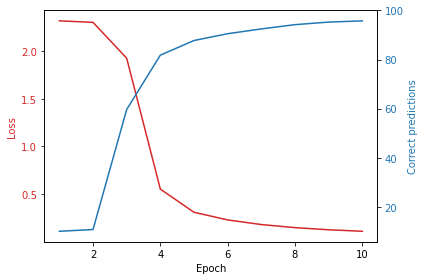

In [21]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(1, 11), loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Correct predictions', color=color)
ax2.plot(np.arange(1, 11), accuracy, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()